In [1]:
import xarray as xr

#import netCDF4 as nc

import numpy as np
import pandas as pd

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import maptools
import geopy.distance

from datetime import datetime
import os
import matplotlib.pyplot as plt

%matplotlib notebook

### Determine which transect IDs are within northern Monterey Bay study area
The CDIP MOP nearshore wave model is split into transects or stretches of the nearshore that have certain transect IDs. To reduce the amount of data to download from the THREDDs server, this section masks out the transect IDs of interest which we will use later to download significant wave height and wave direction outputs from the CDIP MOP model.

In [2]:
#read in transects file and name columns (based off 'CA_v1.1_transect_def_meta.txt')
df_transects = pd.read_csv('CA_v1.1_transect_def.csv',header=None,delimiter='\t')
df_transects.columns=['seqnum','transect','bklon','bklat','predlon','predlat','preddep','shorenorm','typeflag']
df_transects.head()

,seqnum,transect,bklon,bklat,predlon,predlat,preddep,shorenorm,typeflag
0,1,D0001,-117.1241,32.5343,-117.12917,32.53426,-10.03,269.46,1
1,2,D0002,-117.1241,32.5352,-117.12917,32.53524,-10.03,270.54,1
2,3,D0003,-117.1241,32.5361,-117.12918,32.53587,-10.01,266.93,1
3,4,D0004,-117.1242,32.5370,-117.12925,32.53678,-10.00,267.04,1
4,5,D0005,-117.1242,32.5379,-117.12933,32.53771,-10.02,267.48,1


In [3]:
#need to extract these ranges to use as a mask to gather other data
#found these values by zooming in on plot of all transects to find the straight chunk of the northern bay
#lat = 36.80 to 36.96
#lon - -121.975 to -121.800

#find where the prediction latitudes are between specified range
lat_range = df_transects.query('36.8 <= predlat <= 36.96')

#find where prediction longitudes are between specified range
lon_range = df_transects.query('-121.93 <= predlon <= -121.800')

#merge lat_range and lon_range where they overlap
N_bay = lat_range.merge(lon_range)

<IPython.core.display.Javascript object>


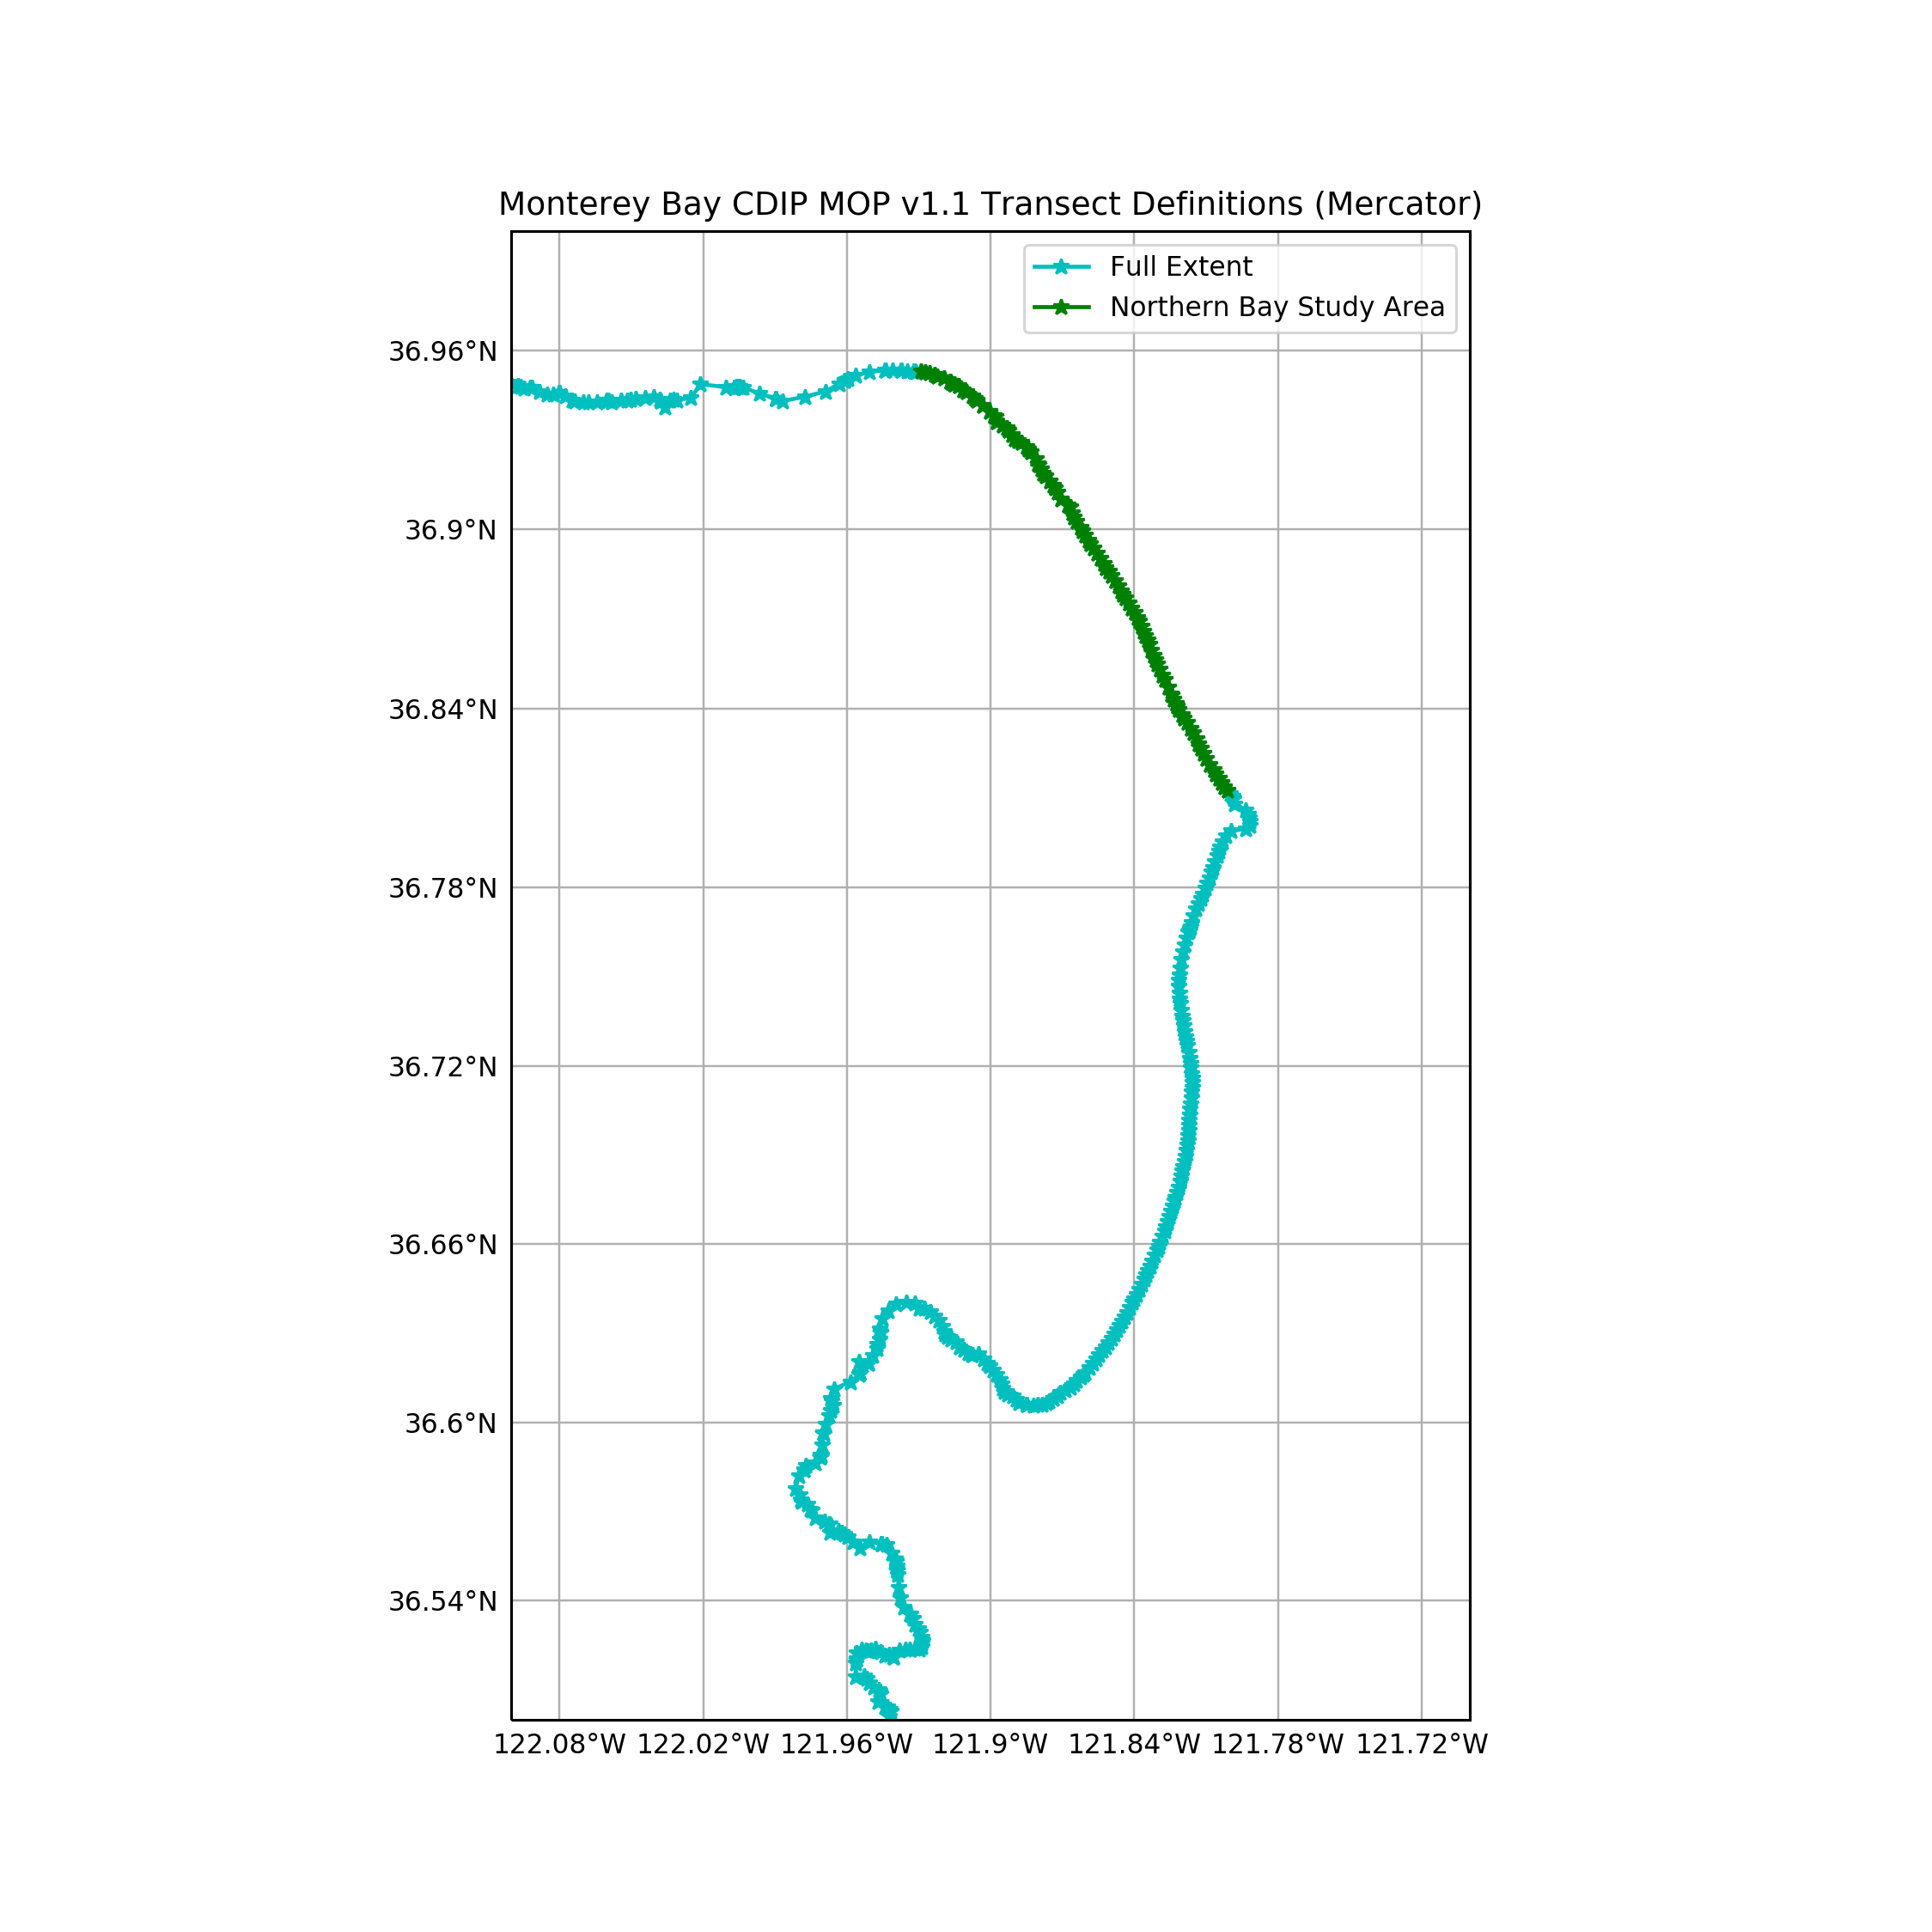

In [4]:
#map study area over entire bay for context
extent = [-122.1, -121.7, 36.5, 37.0]

plt.figure(figsize=[10,10])
ax = maptools.make_map(projection=ccrs.Mercator())
ax.set_extent(extent)

plt.plot(df_transects['predlon'],df_transects['predlat'],color='c',marker='*',label='Full Extent',transform=ccrs.Geodetic(),);
plt.plot(N_bay['predlon'],N_bay['predlat'],color='g',marker='*',label='Northern Bay Study Area',transform=ccrs.Geodetic(),);
plt.title('Monterey Bay CDIP MOP v1.1 Transect Definitions (Mercator)',fontsize=12);
plt.legend();

In [5]:
print('# of transect IDs in study area: ',len(N_bay['transect']))
#note: the first transect ID in the list corresponds to the furthest south

# of transect IDs in study area:  107


### Load in necessary data


In [6]:
#open MO900 to pull wave time info later
MO900 = xr.open_dataset('https://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/model/MOP_alongshore/MO900_hindcast.nc')
MO900

<xarray.Dataset>
Dimensions:                     (metaBoundsCount: 2, waveFrequency: 20, waveTime: 162144)
Coordinates:
  * waveTime                    (waveTime) datetime64[ns] 2000-01-01 ...
  * waveFrequency               (waveFrequency) float32 0.04 0.045 0.05 ...
    metaLatitude                float32 ...
    metaLongitude               float32 ...
Dimensions without coordinates: metaBoundsCount
Data variables:
    waveTimeBounds              (waveTime, metaBoundsCount) datetime64[ns] ...
    waveFlagPrimary             (waveTime) float32 ...
    waveFlagSecondary           (waveTime) float32 ...
    waveHs                      (waveTime) float32 ...
    waveTp                      (waveTime) float32 ...
    waveTa                      (waveTime) float32 ...
    waveDp                      (waveTime) float32 ...
    waveModelInputSource        (waveTime) object ...
    waveDm                      (waveTime) float32 ...
    waveSxy                     (waveTime) float32 ...
    wa

In [7]:
Hs = pd.read_csv('NBay_Hs_120318.csv')
Dp = pd.read_csv('NBay_Dp_120318.csv')
SN = pd.read_csv('NBay_ShoreNorm_120818.csv')

In [8]:
#add wavetime
Hs['waveTime'] = MO900['waveTime']
Hs['waveTime'] = pd.to_datetime(Hs['waveTime']) #convert to datetime

#change from data frame index to datetime index
Hs = Hs.set_index('waveTime')
Hs.drop(['transect'], axis=1, inplace=True) #get rid of transect column
Hs.head()

,MO900,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,0.533468,0.511141,0.513148,0.507124,0.499805,0.494870,0.481238,0.466514,0.458806,0.453327,...,0.385913,0.382470,0.381199,0.381199,0.376034,0.371687,0.368150,0.362153,0.357071,0.354790
2000-01-01 01:00:00,0.521261,0.500008,0.502573,0.498744,0.493048,0.485635,0.473501,0.459688,0.451617,0.446079,...,0.382973,0.380266,0.379427,0.379427,0.374450,0.370294,0.367187,0.361954,0.357370,0.355230
2000-01-01 02:00:00,0.518856,0.496071,0.498229,0.495404,0.489981,0.482511,0.473212,0.460108,0.452171,0.447559,...,0.376060,0.372922,0.371896,0.371896,0.366666,0.362463,0.359034,0.353273,0.348799,0.346660
2000-01-01 03:00:00,0.533961,0.511753,0.513689,0.512111,0.507094,0.498969,0.490307,0.478116,0.470019,0.465595,...,0.380167,0.377064,0.376086,0.376086,0.370704,0.366336,0.362822,0.357345,0.353109,0.351235
2000-01-01 04:00:00,0.536233,0.516214,0.517610,0.516442,0.511750,0.505660,0.497028,0.484521,0.477338,0.473063,...,0.373307,0.369500,0.368387,0.368387,0.362544,0.358497,0.354861,0.350032,0.346050,0.344932


In [9]:
#same for SN
SN['waveTime'] = MO900['waveTime']
SN['waveTime'] = pd.to_datetime(SN['waveTime']) #convert to datetime

#change from data frame index to datetime index
SN = SN.set_index('waveTime')
SN.drop(['transect'], axis=1, inplace=True) #get rid of transect column
SN.head()

,MO900,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,247.529999,245.529999,245.020004,243.479996,243.029999,242.970001,245.479996,247.979996,248.5,249.009995,...,218.009995,215.5,212.210007,207.389999,208.5,210.0,207.5,207.520004,207.020004,206.009995
2000-01-01 01:00:00,247.529999,245.529999,245.020004,243.479996,243.029999,242.970001,245.479996,247.979996,248.5,249.009995,...,218.009995,215.5,212.210007,207.389999,208.5,210.0,207.5,207.520004,207.020004,206.009995
2000-01-01 02:00:00,247.529999,245.529999,245.020004,243.479996,243.029999,242.970001,245.479996,247.979996,248.5,249.009995,...,218.009995,215.5,212.210007,207.389999,208.5,210.0,207.5,207.520004,207.020004,206.009995
2000-01-01 03:00:00,247.529999,245.529999,245.020004,243.479996,243.029999,242.970001,245.479996,247.979996,248.5,249.009995,...,218.009995,215.5,212.210007,207.389999,208.5,210.0,207.5,207.520004,207.020004,206.009995
2000-01-01 04:00:00,247.529999,245.529999,245.020004,243.479996,243.029999,242.970001,245.479996,247.979996,248.5,249.009995,...,218.009995,215.5,212.210007,207.389999,208.5,210.0,207.5,207.520004,207.020004,206.009995


In [10]:
#same for Dp
Dp['waveTime'] = MO900['waveTime']
Dp['waveTime'] = pd.to_datetime(Dp['waveTime']) #convert to datetime

#change from data frame index to datetime index
Dp = Dp.set_index('waveTime')
Dp.drop(['transect'], axis=1, inplace=True) #get rid of transect column
Dp.head()

,MO900,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,240.214600,250.091522,250.987717,252.281189,251.077087,248.319565,250.074097,253.687531,252.709930,250.954025,...,220.035217,219.246124,218.719574,218.719574,216.968582,216.549927,215.981979,214.062119,212.000732,210.861191
2000-01-01 01:00:00,240.371017,250.332703,250.800049,251.854416,250.481995,247.739838,250.813217,253.357086,253.163055,251.786133,...,218.627365,217.827393,217.315460,217.315460,215.590027,215.172226,214.622604,212.855865,210.885239,209.843765
2000-01-01 02:00:00,240.306503,250.503006,250.670135,251.657135,251.480026,249.119995,249.765503,252.410278,252.592621,251.220657,...,216.344498,215.526260,215.043488,215.043488,213.368515,213.020615,212.552963,210.907455,209.011597,208.108322
2000-01-01 03:00:00,227.552155,250.360962,250.439667,251.218658,251.077484,248.589279,248.824173,251.742615,252.266251,250.878922,...,215.595520,214.820465,214.354340,214.354340,212.757263,212.456757,212.042786,210.443481,208.643814,207.748871
2000-01-01 04:00:00,227.575287,250.754333,250.679474,251.325195,250.980682,248.293045,248.266815,251.597427,252.245087,250.791138,...,214.548080,213.886765,213.439194,213.439194,211.914688,211.593948,211.235382,209.797485,208.075500,207.174408


"NBay_Dp_df" is the angle that the waves are approaching, but doesn't consider the angle of the shoreline. The "metaShoreNormal" gives the angle that is shorenormal to the shoreline at the current transect. Here, we use these two variables to calculate the angle between wave approach and shore normal, needed by the CERC equation later.

If Dp > SN, then waves are approaching from the north of shore normal, so transport is negative (southward)

If Dp < SN, then waves are approaching from the south of shore normal, so transport is positive (northward)

In [11]:
#now compute angle of approach to shoreline
SN_Dp = SN - Dp
SN_Dp.head()

,MO900,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,7.315399,-4.561523,-5.967712,-8.801193,-8.047089,-5.349564,-4.594101,-5.707535,-4.209930,-1.944031,...,-2.025223,-3.746124,-6.509567,-11.329575,-8.468582,-6.549927,-8.481979,-6.542114,-4.980728,-4.851196
2000-01-01 01:00:00,7.158981,-4.802704,-5.780045,-8.374420,-7.451996,-4.769836,-5.333221,-5.377090,-4.663055,-2.776138,...,-0.617371,-2.327393,-5.105453,-9.925461,-7.090027,-5.172226,-7.122604,-5.335861,-3.865234,-3.833771
2000-01-01 02:00:00,7.223495,-4.973007,-5.650131,-8.177139,-8.450027,-6.149994,-4.285507,-4.430283,-4.092621,-2.210663,...,1.665497,-0.026260,-2.833481,-7.653488,-4.868515,-3.020615,-5.052963,-3.387451,-1.991592,-2.098328
2000-01-01 03:00:00,19.977844,-4.830963,-5.419662,-7.738663,-8.047485,-5.619278,-3.344177,-3.762619,-3.766251,-1.868927,...,2.414474,0.679535,-2.144333,-6.964340,-4.257263,-2.456757,-4.542786,-2.923477,-1.623810,-1.738876
2000-01-01 04:00:00,19.954712,-5.224335,-5.659470,-7.845200,-7.950684,-5.323044,-2.786819,-3.617432,-3.745087,-1.781143,...,3.461914,1.613235,-1.229187,-6.049194,-3.414688,-1.593948,-3.735382,-2.277481,-1.055496,-1.164413


<IPython.core.display.Javascript object>


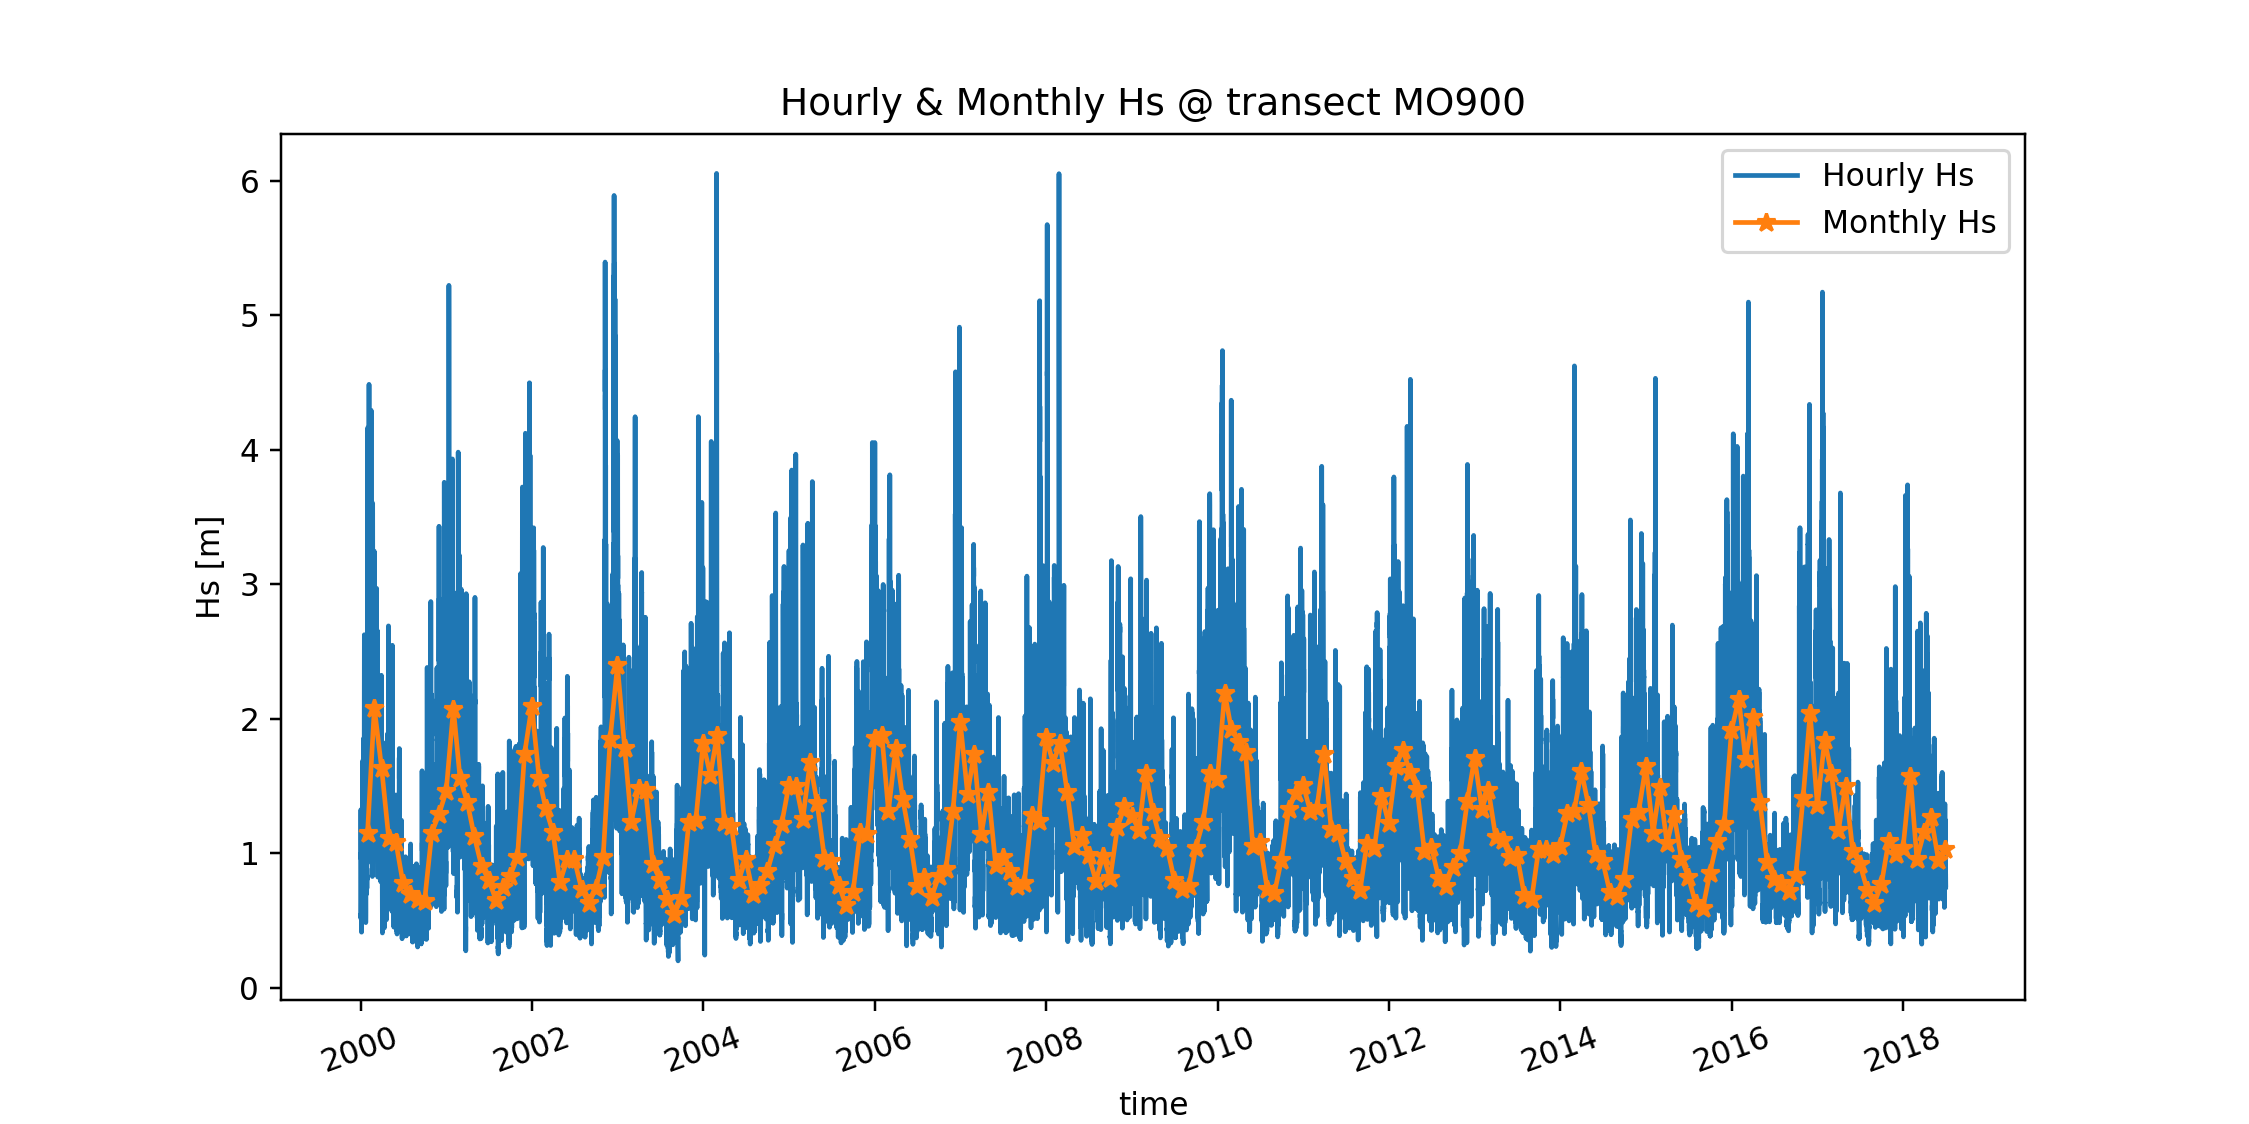

In [12]:
#get monthly averages of Hs, Dp, SN_Dp to see trends
Hs_monthly = Hs.resample('M').mean()
SN_Dp_monthly = Hs.resample('M').mean()

#hourly averages
Hs_daily = Hs.resample('D').mean()

#check it out
plt.figure(figsize=[10,5])
plt.title('Hs @ transect MO900')
plt.title('Hourly & Monthly Hs @ transect MO900')
plt.plot(Hs['MO900'],label='Hourly Hs')
#plt.plot(Hs_daily['MO900'],'-*',label='daily Hs')
plt.plot(Hs_monthly['MO900'],'-*',label='Monthly Hs')
plt.ylabel('Hs [m]')
plt.xlabel('time')
plt.xticks(rotation =20);
plt.legend();

Winter months = November - March

Summer months = April - October

In the graph of significant wave height with time, we can see peaks in wave height during the winter and troughs in significant wave height in the summer. 

<IPython.core.display.Javascript object>


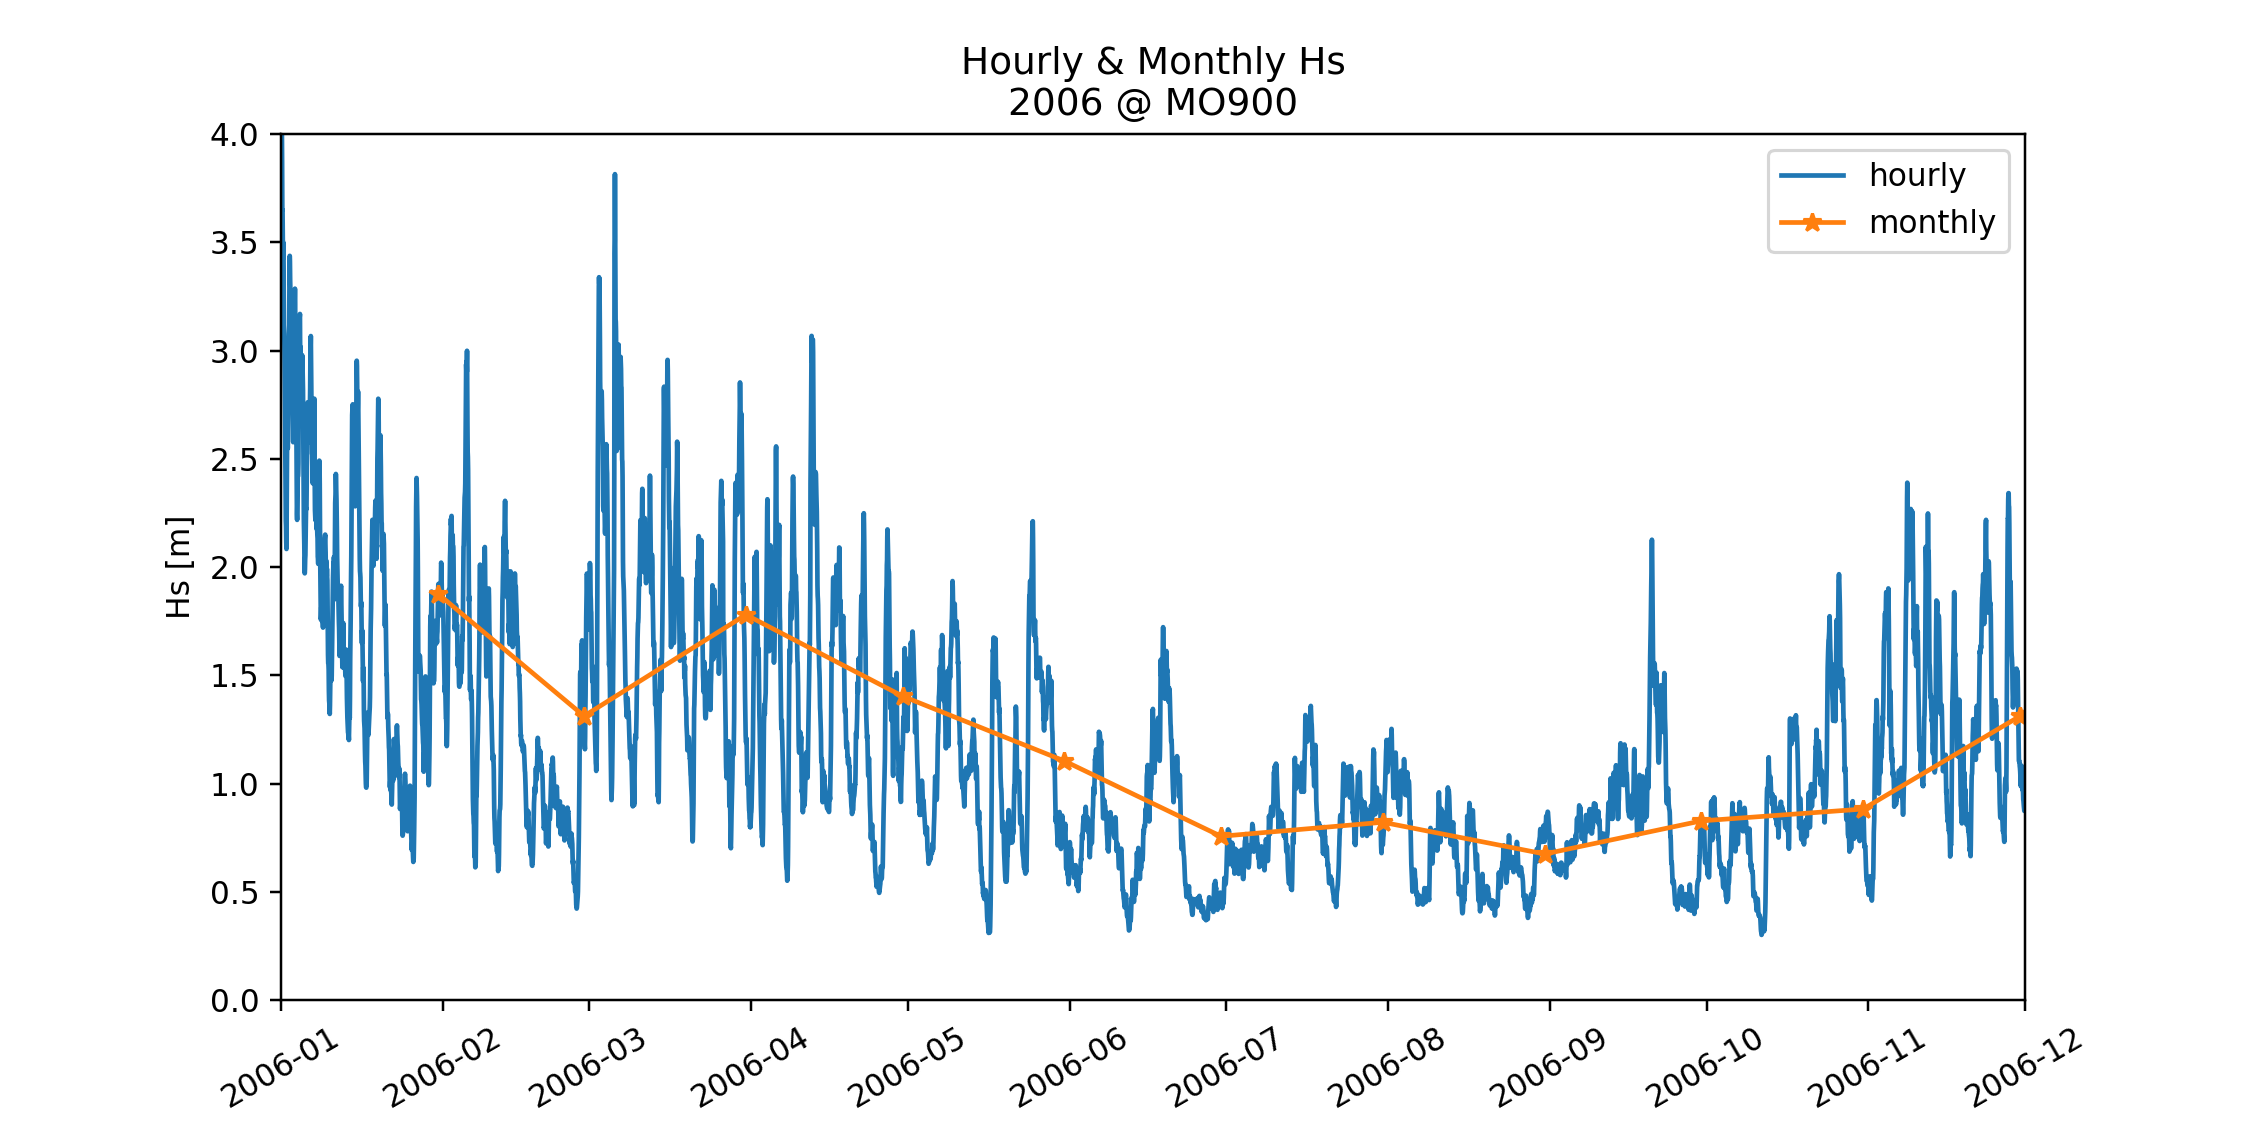

In [13]:
#check it out for 1 year
Hs_yr2006 = Hs['2006-01-01':'2006-12-31']
Hs_yr2006_monthly = Hs_yr2006.resample('M').mean()

#daily
#Hs_yr2006_daily = yr2006.resample('D').mean()

plt.figure(figsize=[10,5])

plt.title('Hourly & Monthly Hs'+ '\n' +'2006 @ MO900')
plt.plot(Hs_yr2006['MO900'],label='hourly')
plt.plot(Hs_yr2006_monthly['MO900'],'-*',label='monthly')
#plt.plot(Hs_yr2006_daily['MO900'],'-*',label='daily')
plt.ylabel('Hs [m]')
plt.xlabel('time')
plt.xticks(rotation =30)
plt.xlim('2006-01','2006-12')
plt.ylim(0,4)
plt.legend();


The graph above shows significant wave height over the year 2006 at transect MO900, which is the southernmost transect in the study area near Moss Landing, CA. Hs is greater in magnitude in winter than summer. The end of winter may not actually appear until the end of May...so using different seasonal definitions may be necessary.

<IPython.core.display.Javascript object>


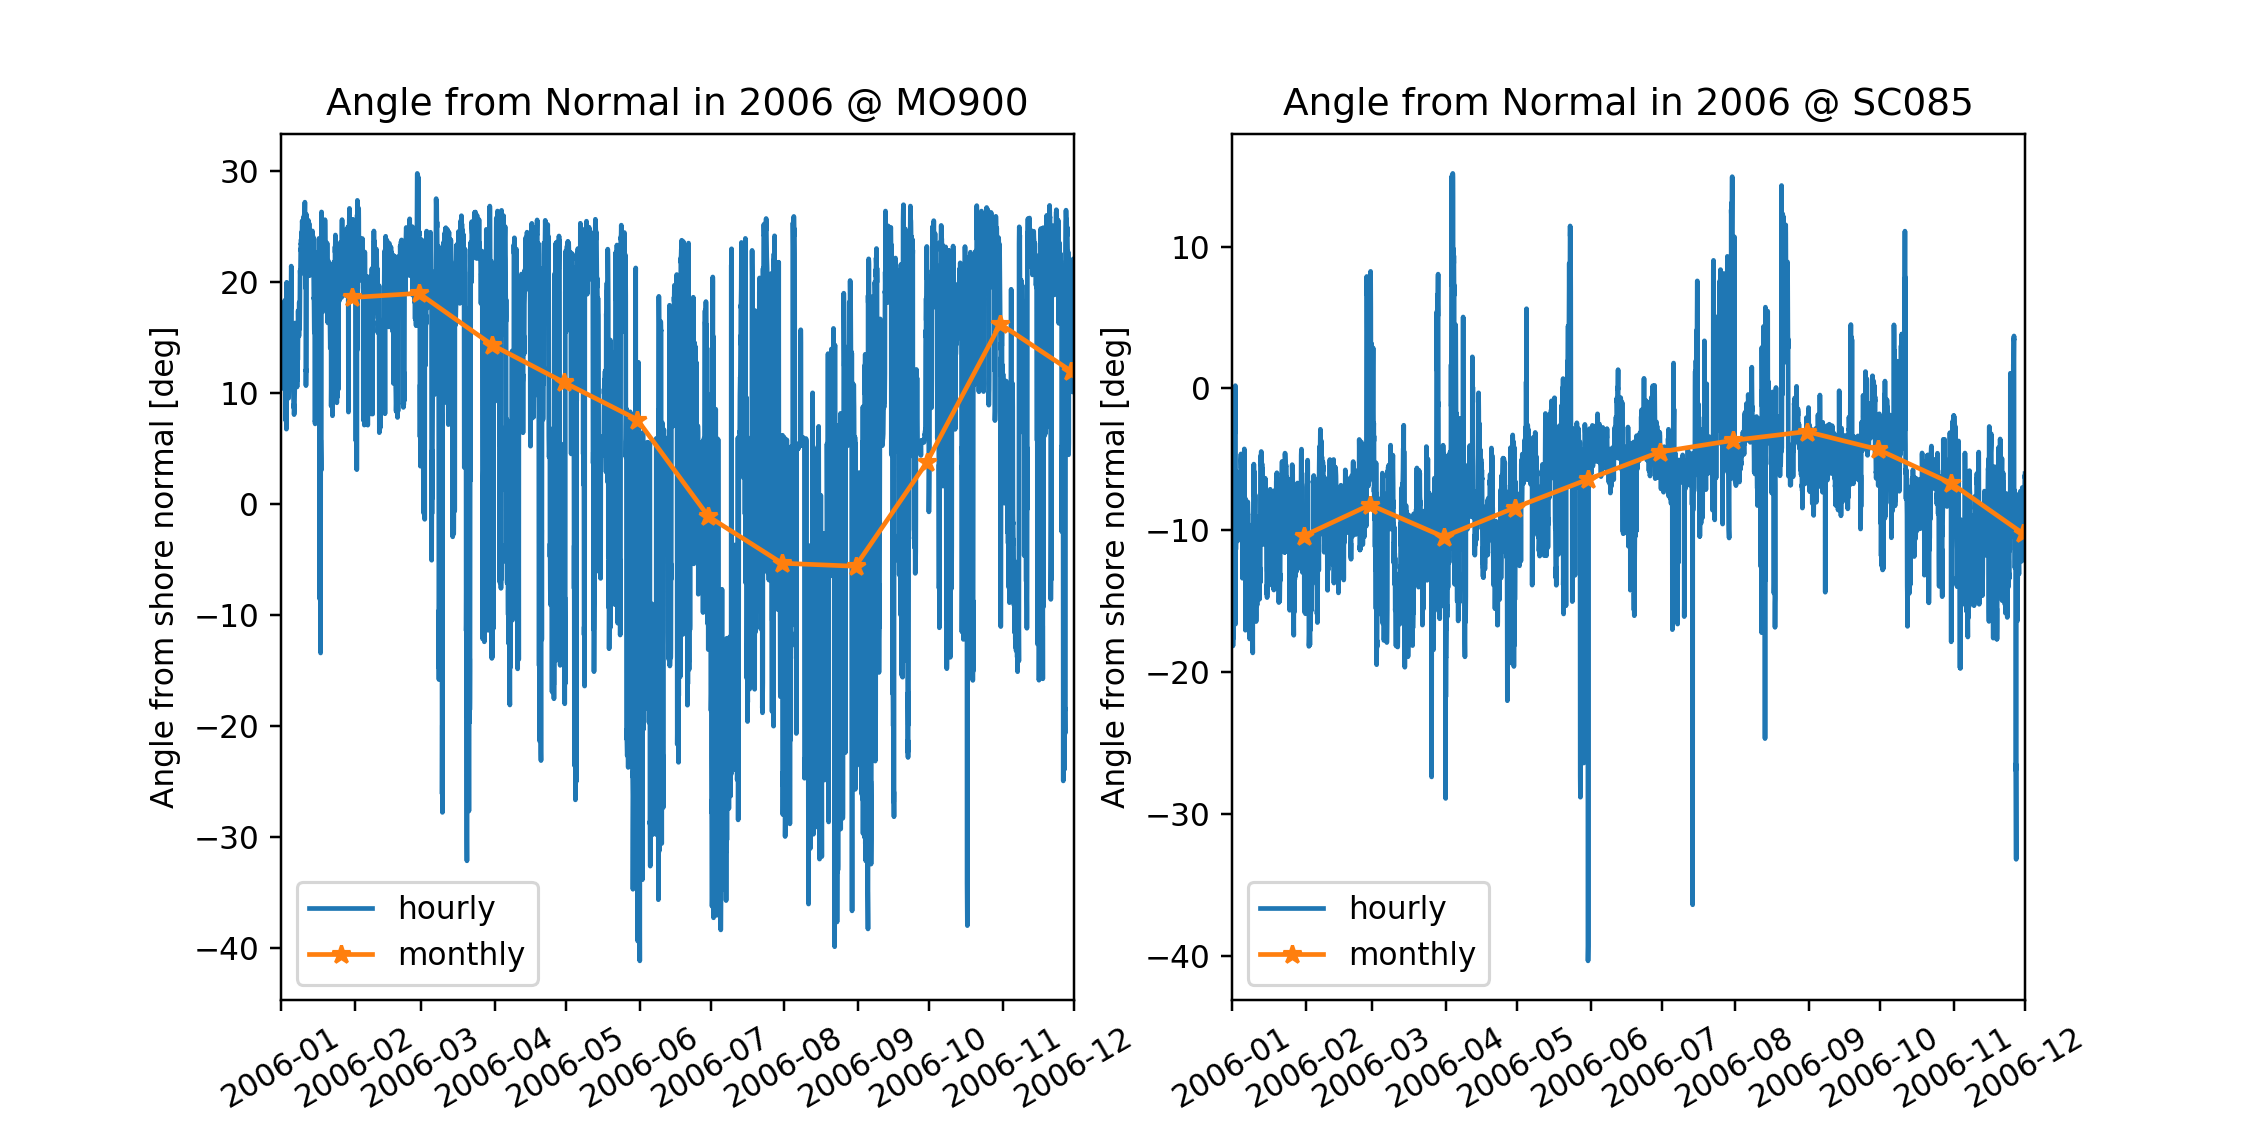

In [14]:
#check it out for 1 year
SN_Dp_yr2006 = SN_Dp['2006-01-01':'2006-12-31']
SN_Dp_yr2006_monthly = SN_Dp_yr2006.resample('M').mean()

plt.figure(figsize=[10,5])


plt.subplot(1,2,1)
plt.title('Angle from Normal in 2006 @ MO900')
plt.plot(SN_Dp_yr2006['MO900'],label='hourly')
plt.plot(SN_Dp_yr2006_monthly['MO900'],'-*',label='monthly')
plt.ylabel('Angle from shore normal [deg]')
plt.xlabel('time')
plt.xticks(rotation =30)
plt.xlim('2006-01','2006-12')
plt.legend();


plt.subplot(1,2,2)
plt.title('Angle from Normal in 2006 @ SC085')
plt.plot(SN_Dp_yr2006['SC085'],label='hourly')
plt.plot(SN_Dp_yr2006_monthly['SC085'],'-*',label='monthly')
plt.ylabel('Angle from shore normal [deg]')
plt.xlabel('time')
plt.xticks(rotation =30)
plt.xlim('2006-01','2006-12')
plt.legend();

The chart above shows the angle of wave approach from shore normal for the year 2006 at MO900 (near Moss Landing) and SC085 (near Santa Cruz). Positive values indicate northward (coming from the south) moving waves and negative values indicate southward moving (coming from the north) waves. 

In the winter at MO900 we would expect waves approaching from the south driving northward sediment transport, and waves coming more from closer to shore normal in the summer.

In the winter a SC085 we would expect waves approaching from the north driving southward sediment transprot, and waves coming more from a closer to shore normal direction in the summer.

This is a single year's calcuations at discrete points, so this information may not be representative of the shoreline...but we'll see how we do moving forward.

### Follow steps to build model:
#### 1) Define parameters, 2) Define model equations, 3) Step forward in time

In [15]:
#define parameters
K = 0.39 #unitless (Inman & Komar 1970)
rho = 1000 #kg/m^3
g = 9.8 #m/s^2 
gammab = 0.5 #related to beach steepness, choosing medium value

hcl = 20 #closure depth....guessing for now
B = 20 #height of berm or cliff backing beach....guessing for now

In [16]:
#separate lats and lons from transect info CSV to calculate dy
coords1 = np.array([N_bay['predlat'].iloc[:-1], N_bay['predlon'].iloc[:-1]]).T
coords2 = np.array([N_bay['predlat'].iloc[1:], N_bay['predlon'].iloc[1:]]).T

dy = np.zeros([106,1])

for ii in np.arange(0,106):
    dy[ii] = geopy.distance.distance(coords1[ii,:],coords2[ii,:]).m

np.shape(dy)

(106, 1)

In [17]:
#Hs.iloc[:,1] <- use this to index along the dataframes
test = np.shape(SN_Dp)
test[0]

162144

In [18]:
#calculate Q
Q_lst = np.zeros(np.shape(Hs))
Q_lst = (K/(16*np.sqrt(gammab)))*rho*(g**(3/2))*(Hs**(5/2))*np.sin(2*SN_Dp)
Q_lst.head()

,MO900,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,193.578558,-58.702913,117.676620,183.625209,70.352318,174.243711,-39.820908,143.572634,-127.283943,99.364014,...,77.177377,-89.482301,-41.505834,58.770806,86.401331,-45.296395,82.694529,-41.319080,41.195331,21.730803
2000-01-01 01:00:00,204.080187,33.586681,159.983184,160.297861,-129.994831,19.925907,154.397272,147.122586,-14.278791,93.823061,...,-90.619121,94.145109,66.362226,-78.983828,-90.653483,70.186457,-85.896991,79.022243,-80.125661,-78.159532
2000-01-01 02:00:00,195.311814,91.273714,176.763798,110.020526,165.131931,45.021861,-122.792344,-81.208260,-137.492325,135.756798,...,-17.267339,-4.714928,51.552458,-34.816272,26.448425,20.042331,51.435466,-37.037973,56.663464,65.094318
2000-01-01 03:00:00,170.518699,46.547024,197.571986,-45.371424,73.087450,180.523523,-70.170770,-158.208241,-151.966496,87.843698,...,-93.600346,90.267138,83.618668,-89.744539,-69.872246,84.169103,-27.902056,34.109165,8.292284,25.505224
2000-01-01 04:00:00,178.675491,172.942456,193.282688,-3.560051,38.080004,180.660927,119.993422,-140.738148,-155.584371,66.477553,...,53.821569,-7.440652,-54.990934,39.293431,-43.474281,3.766842,-73.577239,75.711801,-63.890389,-53.663965


In [19]:
Q_daily = Q_lst.resample('D').mean()
Q_daily.head()

,MO900,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01,-172.908427,-287.694823,-11.336109,12.523565,-95.449135,-13.714757,13.264583,-65.119896,-65.493526,-8.046100,...,7.263858,14.556190,-2.054671,-0.925232,-15.737324,38.438303,0.707083,15.820687,11.158726,48.010920
2000-01-02,54.068719,-8.049542,-196.640278,68.892832,-0.251153,-57.542258,-104.425281,-114.848957,-267.738382,-130.530082,...,-66.091302,21.251150,33.151859,-0.837680,18.232942,103.994419,-149.801863,28.912685,-129.558272,31.572037
2000-01-03,-10.449762,-608.487959,53.112416,-105.702382,98.349442,93.596187,-178.117397,-183.810406,-39.327923,122.971347,...,-54.871754,58.692524,71.198309,-67.075101,-39.945935,-46.999303,-21.204249,-29.980846,-28.634090,77.300164
2000-01-04,94.222910,-50.200000,26.071572,-13.318108,-41.627269,19.768924,41.518760,-26.977407,31.926396,21.541524,...,7.683496,23.788462,37.187619,-40.650938,-7.508407,-45.109469,9.371963,12.256368,-45.336207,34.534760
2000-01-05,3.997416,42.512373,-22.048713,76.888128,-14.615691,55.924310,-99.377669,-95.312536,-31.661517,94.717501,...,14.735243,-1.977595,7.359657,-3.996608,-2.277160,14.448091,-5.396022,-4.542169,10.502569,32.259361


<IPython.core.display.Javascript object>


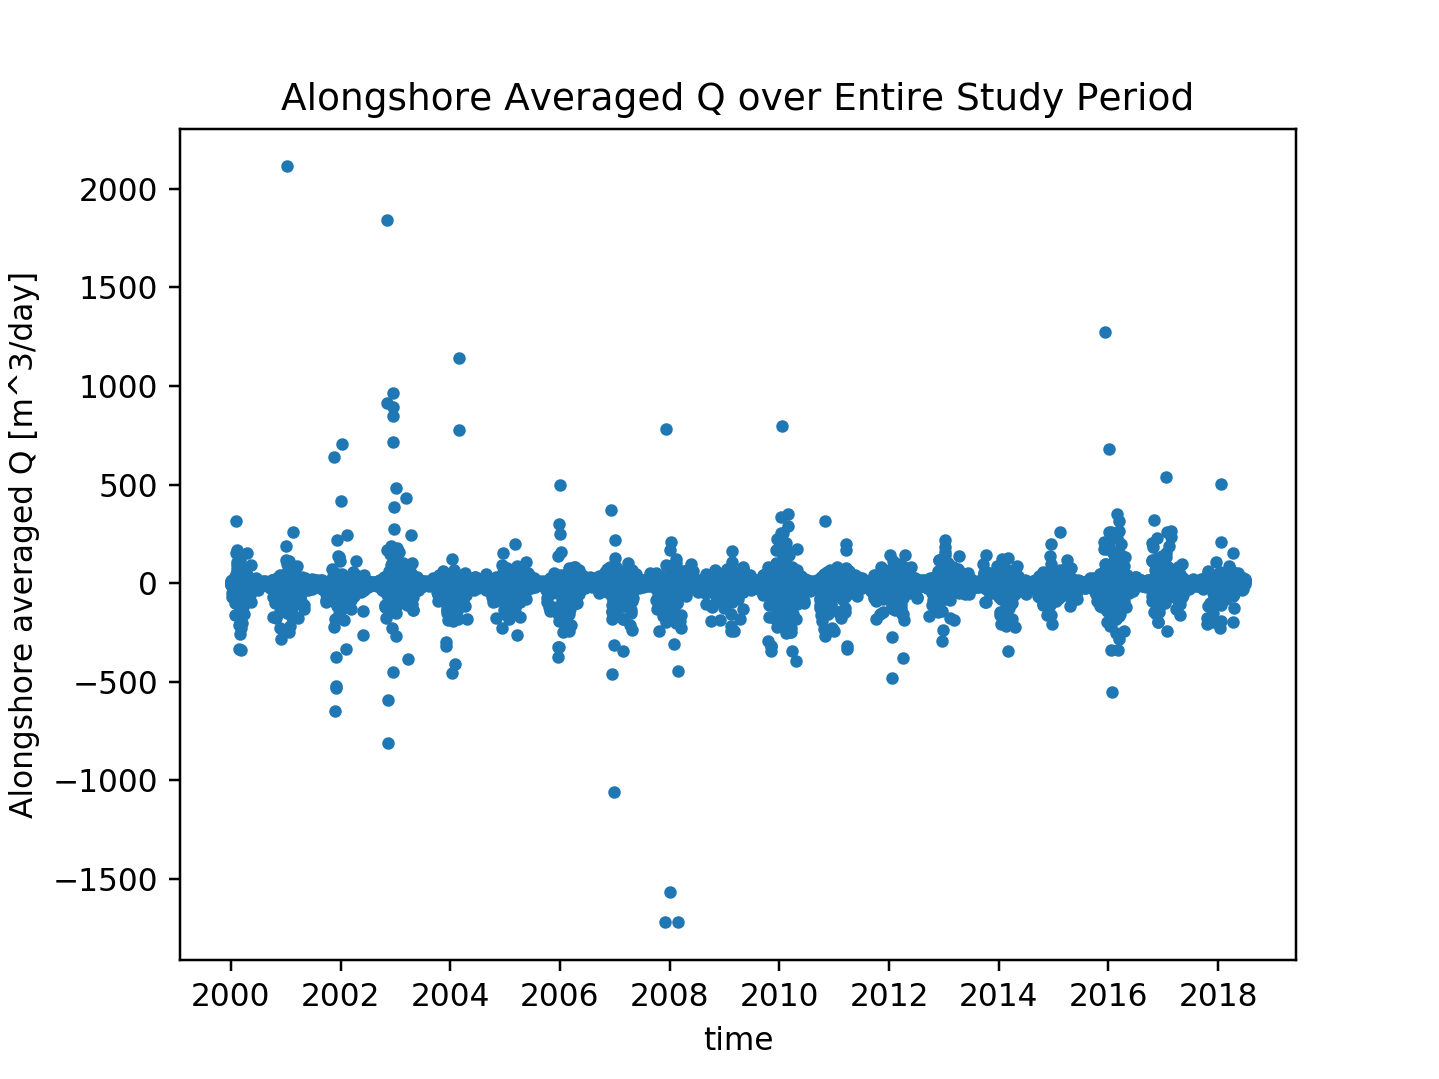

In [20]:
N_bay_Q_daily_mean = Q_daily.mean(axis=1) #alongshore average of Q values 
plt.figure()
plt.title('Alongshore Averaged Q over Entire Study Period')
plt.plot(N_bay_Q_daily_mean,'.')
plt.xlabel('time')
plt.ylabel('Alongshore averaged Q [m^3/day]');

# Now calculate change in shoreline position

In [23]:
dQ_nans = Q_lst.diff(axis=1) #column labels don't make sense anymore
dQ = dQ_nans.drop(columns='MO900')
dQ.head()

,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,MO910,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,-252.281471,176.379532,65.948589,-113.272890,103.891392,-214.064619,183.393542,-270.856577,226.647958,-85.313127,...,120.317243,-166.659678,47.976467,100.276640,27.630526,-131.697726,127.990924,-124.013610,82.514412,-19.464528
2000-01-01 01:00:00,-170.493506,126.396504,0.314676,-290.292691,149.920738,134.471365,-7.274686,-161.401377,108.101852,40.856447,...,-111.166323,184.764230,-27.782883,-145.346053,-11.669655,160.839940,-156.083448,164.919234,-159.147903,1.966128
2000-01-01 02:00:00,-104.038100,85.490084,-66.743272,55.111405,-120.110070,-167.814205,41.584084,-56.284065,273.249123,-134.852945,...,73.963935,12.552411,56.267387,-86.368730,61.264697,-6.406094,31.393136,-88.473439,93.701437,8.430854
2000-01-01 03:00:00,-123.971675,151.024962,-242.943410,118.458874,107.436073,-250.694293,-88.037471,6.241744,239.810194,-192.123892,...,-98.910774,183.867484,-6.648470,-173.363206,19.872293,154.041349,-112.071158,62.011221,-25.816881,17.212940
2000-01-01 04:00:00,-5.733036,20.340232,-196.842739,41.640056,142.580923,-60.667504,-260.731571,-14.846222,222.061924,-193.300099,...,-19.053248,-61.262221,-47.550283,94.284366,-82.767712,47.241123,-77.344081,149.289040,-139.602190,10.226423


In [24]:
#calculate dy/df
dy_df = pd.DataFrame(dy)
dQdy = dQ/dy_df.values[:,0]
dQdy.head()

,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,MO910,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,-1.442120,0.886533,0.377473,-0.588618,0.524941,-0.843546,0.724418,-1.271218,1.123829,-0.439172,...,3.444804,-1.554397,0.778544,inf,0.109373,-0.500914,1.253216,-0.614233,0.459944,-0.120639
2000-01-01 01:00:00,-0.974595,0.635304,0.001801,-1.508495,0.757517,0.529900,-0.028736,-0.757509,0.536021,0.210320,...,-3.182804,1.723254,-0.450850,-inf,-0.046193,0.611757,-1.528282,0.816837,-0.887107,0.012186
2000-01-01 02:00:00,-0.594715,0.429697,-0.382022,0.286384,-0.606890,-0.661291,0.164260,-0.264159,1.354899,-0.694192,...,2.117662,0.117074,0.913086,-inf,0.242510,-0.024366,0.307384,-0.438205,0.522301,0.052254
2000-01-01 03:00:00,-0.708661,0.759094,-1.390547,0.615567,0.542851,-0.987890,-0.347754,0.029295,1.189093,-0.989009,...,-2.831915,1.714891,-0.107889,-inf,0.078662,0.585898,-1.097338,0.307139,-0.143906,0.106684
2000-01-01 04:00:00,-0.032772,0.102236,-1.126679,0.216381,0.720431,-0.239067,-1.029909,-0.069678,1.101089,-0.995064,...,-0.545514,-0.571379,-0.771629,inf,-0.327628,0.179682,-0.757310,0.739421,-0.778157,0.063382


In [25]:
#calculate changes in shoreline position
dx = -(1/(hcl+B))*(dQdy)
dx.head()

,MO901,MO902,MO903,MO904,MO905,MO906,MO907,MO908,MO909,MO910,...,SC076,SC077,SC078,SC079,SC080,SC081,SC082,SC083,SC084,SC085
waveTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,0.036053,-0.022163,-0.009437,0.014715,-0.013124,0.021089,-0.018110,0.031780,-0.028096,0.010979,...,-0.086120,0.038860,-0.019464,-inf,-0.002734,0.012523,-0.031330,0.015356,-0.011499,0.003016
2000-01-01 01:00:00,0.024365,-0.015883,-0.000045,0.037712,-0.018938,-0.013247,0.000718,0.018938,-0.013401,-0.005258,...,0.079570,-0.043081,0.011271,inf,0.001155,-0.015294,0.038207,-0.020421,0.022178,-0.000305
2000-01-01 02:00:00,0.014868,-0.010742,0.009551,-0.007160,0.015172,0.016532,-0.004107,0.006604,-0.033872,0.017355,...,-0.052942,-0.002927,-0.022827,inf,-0.006063,0.000609,-0.007685,0.010955,-0.013058,-0.001306
2000-01-01 03:00:00,0.017717,-0.018977,0.034764,-0.015389,-0.013571,0.024697,0.008694,-0.000732,-0.029727,0.024725,...,0.070798,-0.042872,0.002697,inf,-0.001967,-0.014647,0.027433,-0.007678,0.003598,-0.002667
2000-01-01 04:00:00,0.000819,-0.002556,0.028167,-0.005410,-0.018011,0.005977,0.025748,0.001742,-0.027527,0.024877,...,0.013638,0.014284,0.019291,-inf,0.008191,-0.004492,0.018933,-0.018486,0.019454,-0.001585


<IPython.core.display.Javascript object>


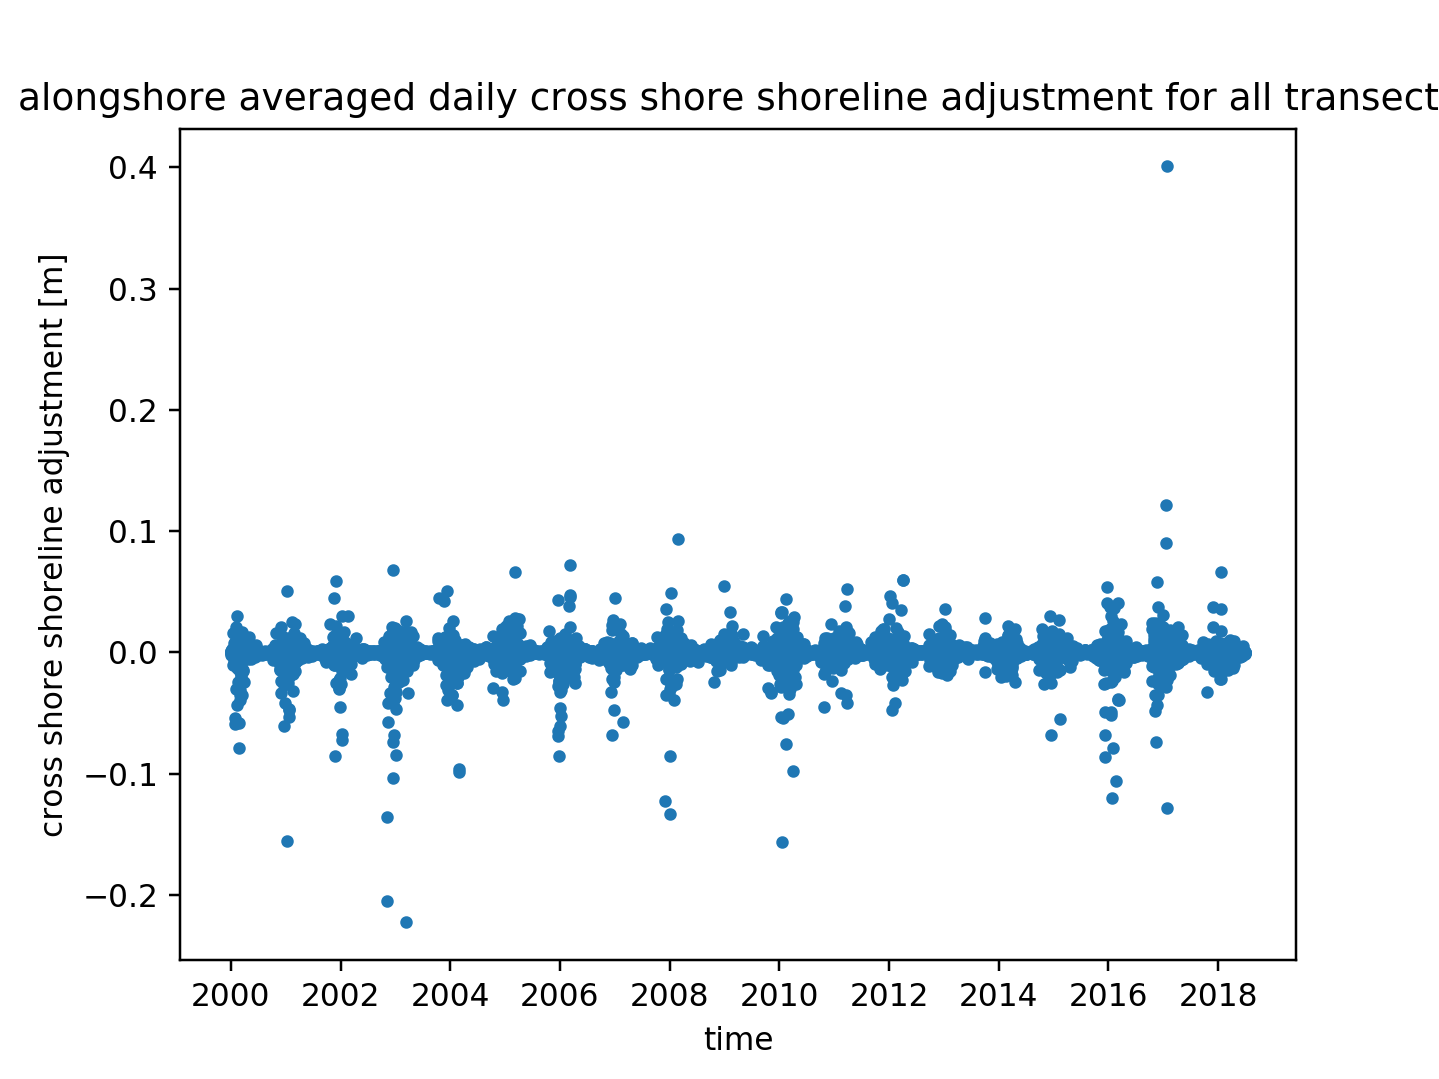

In [26]:
#find dx daily values and plot
dx_daily = dx.resample('D').mean()
N_bay_dx_daily = dx_daily.mean(axis=1)
plt.figure()
plt.plot(N_bay_dx_daily,'.');
plt.title('alongshore averaged daily cross shore shoreline adjustment for all transects')
plt.xlabel('time')
plt.ylabel('cross shore shoreline adjustment [m]');


In [27]:
#make monthly averages to plot more easily (and smooth out data a little more)
dx_monthly = dx.resample('M').mean()
Q_monthly = Q_lst.resample('M').mean()

#add columns for month and year to data frames
dx_monthly['month'] = dx_monthly.index.month
dx_monthly['year'] = dx_monthly.index.year

Q_monthly['month'] = Q_monthly.index.month
Q_monthly['year'] = Q_monthly.index.year

<IPython.core.display.Javascript object>


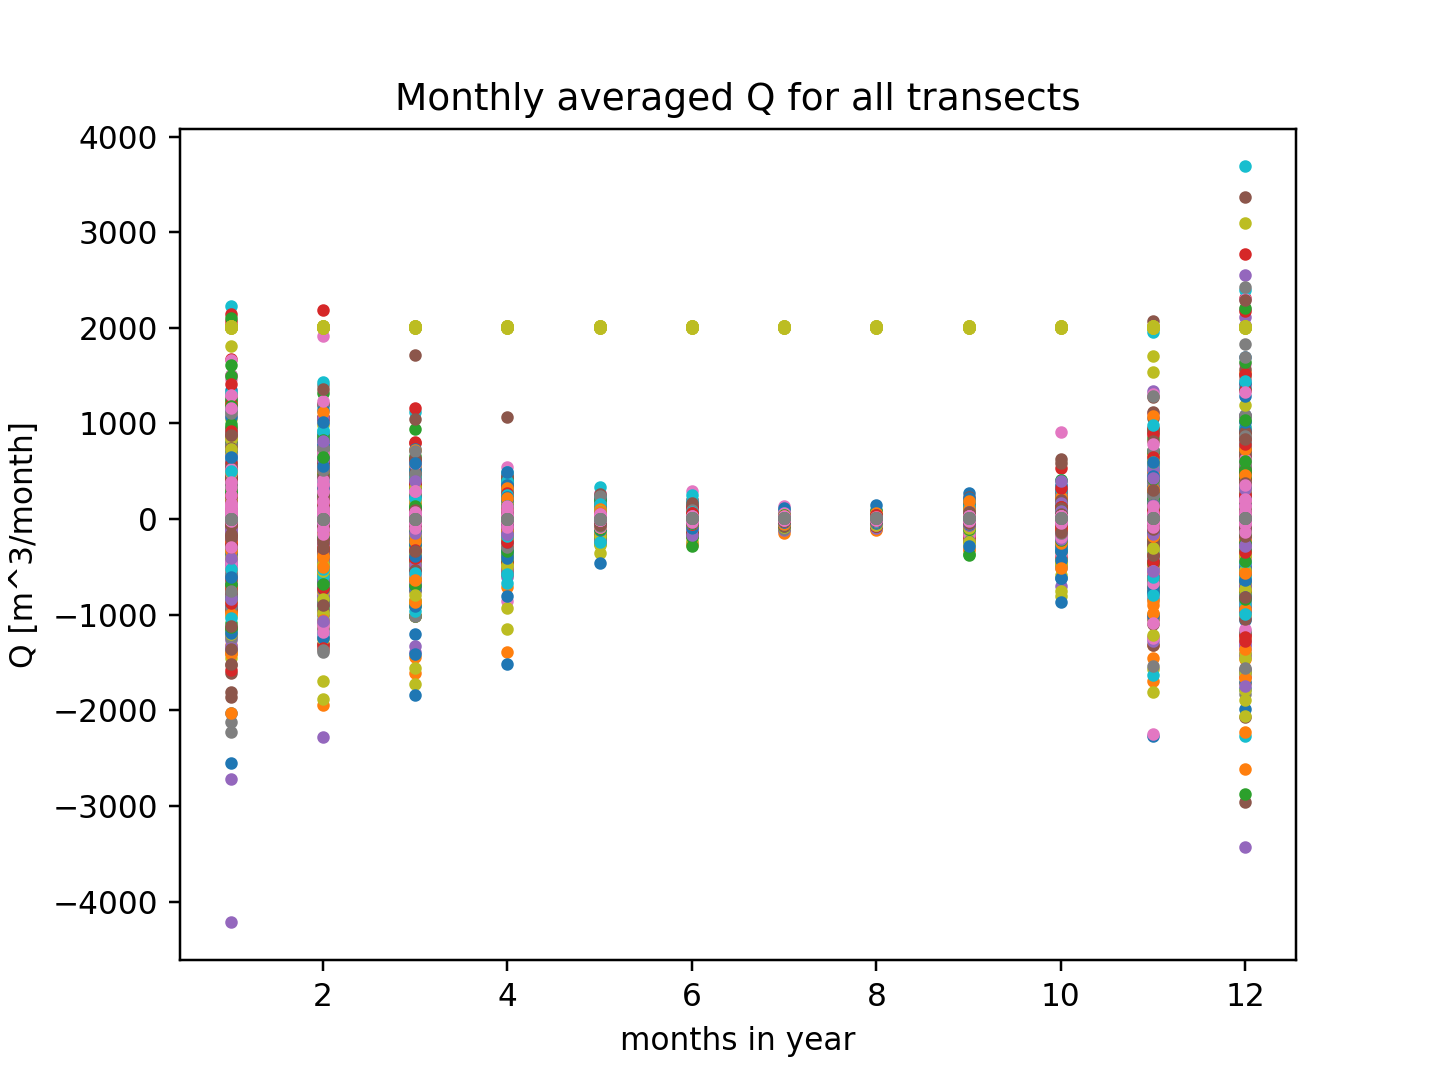

In [28]:
plt.figure()
plt.title('Monthly averaged Q for all transects')
plt.plot(Q_monthly['month'], Q_monthly,'.')
plt.xlabel('months in year')
plt.ylabel('Q [m^3/month]');


<IPython.core.display.Javascript object>


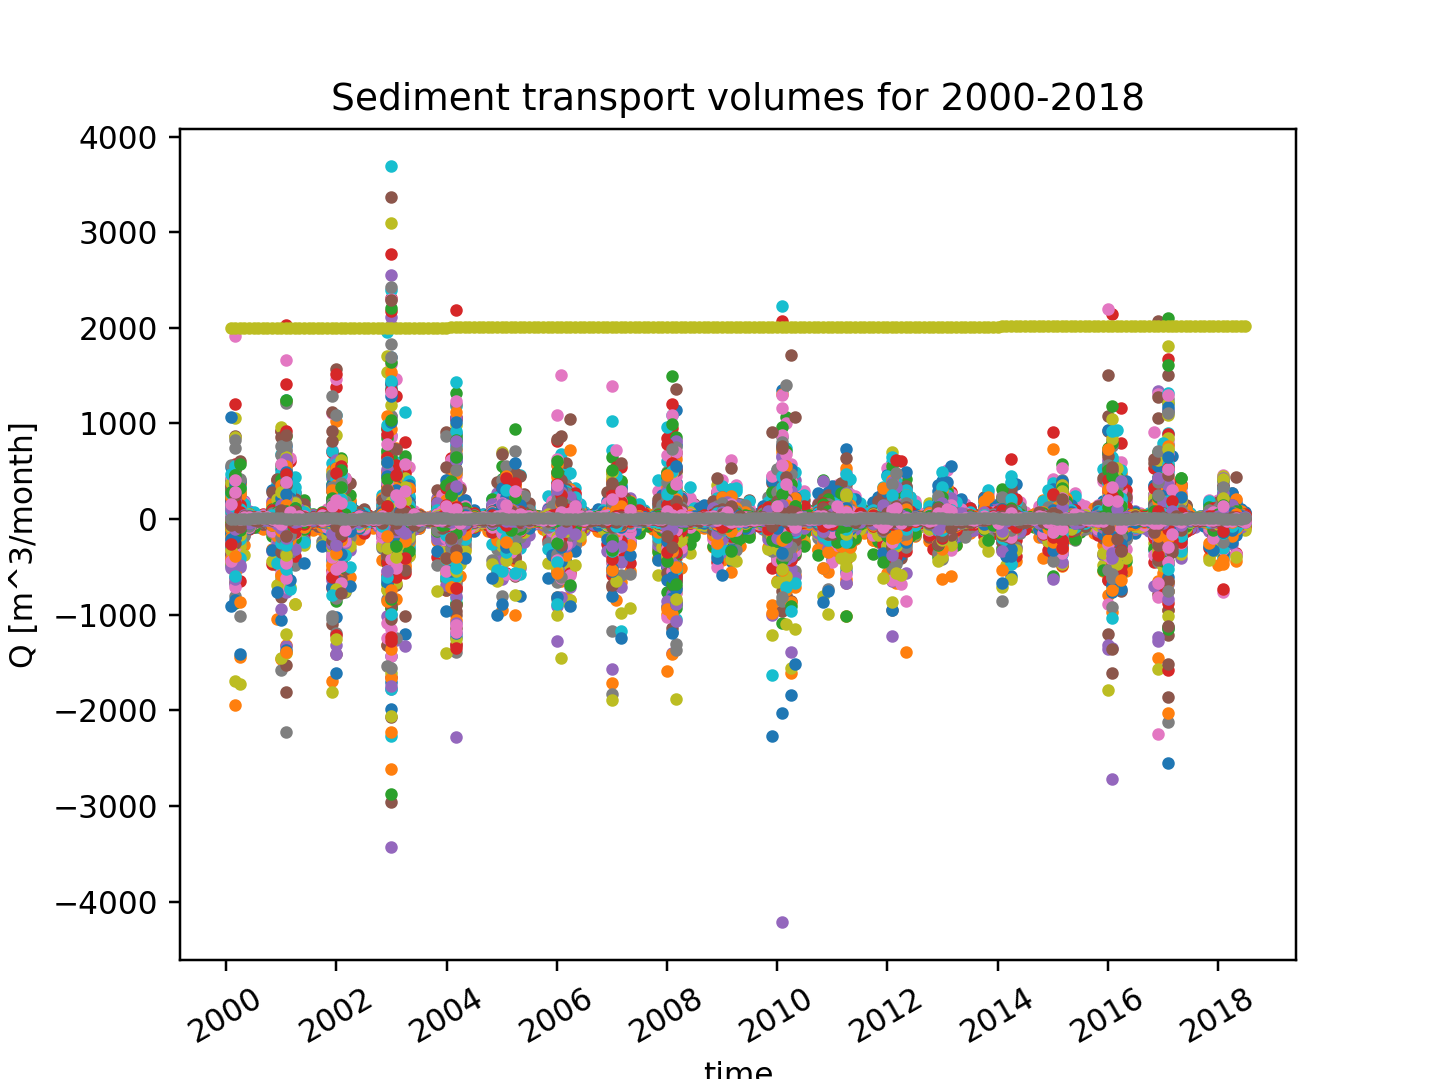

Text(0.5,1,'Sediment transport volumes for 2000-2018')

In [44]:
plt.figure()
plt.plot(Q_monthly,'.');
plt.xticks(rotation=30)
plt.xlabel('time')
plt.ylabel('Q [m^3/month]')
plt.title('Sediment transport volumes for 2000-2018')

<IPython.core.display.Javascript object>


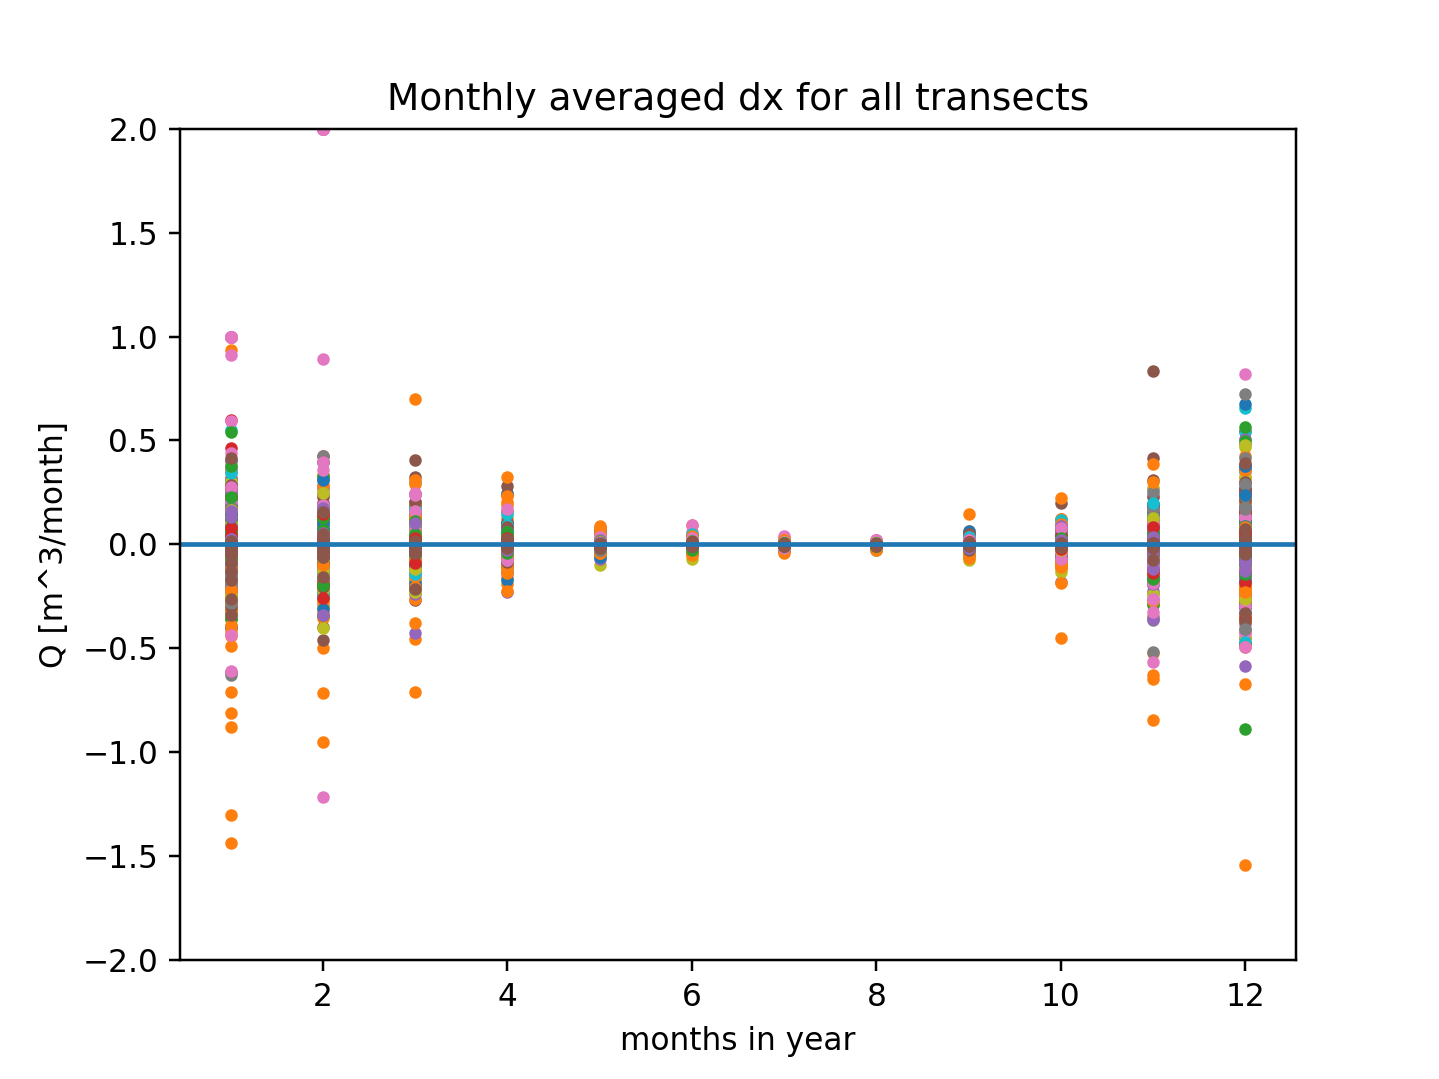

In [38]:
plt.figure()
plt.title('Monthly averaged dx for all transects')
plt.plot(dx_monthly['month'], dx_monthly,'.')
plt.xlabel('months in year')
plt.ylabel('Q [m^3/month]');
plt.ylim(-2,2)
plt.axhline(y=0)

<IPython.core.display.Javascript object>


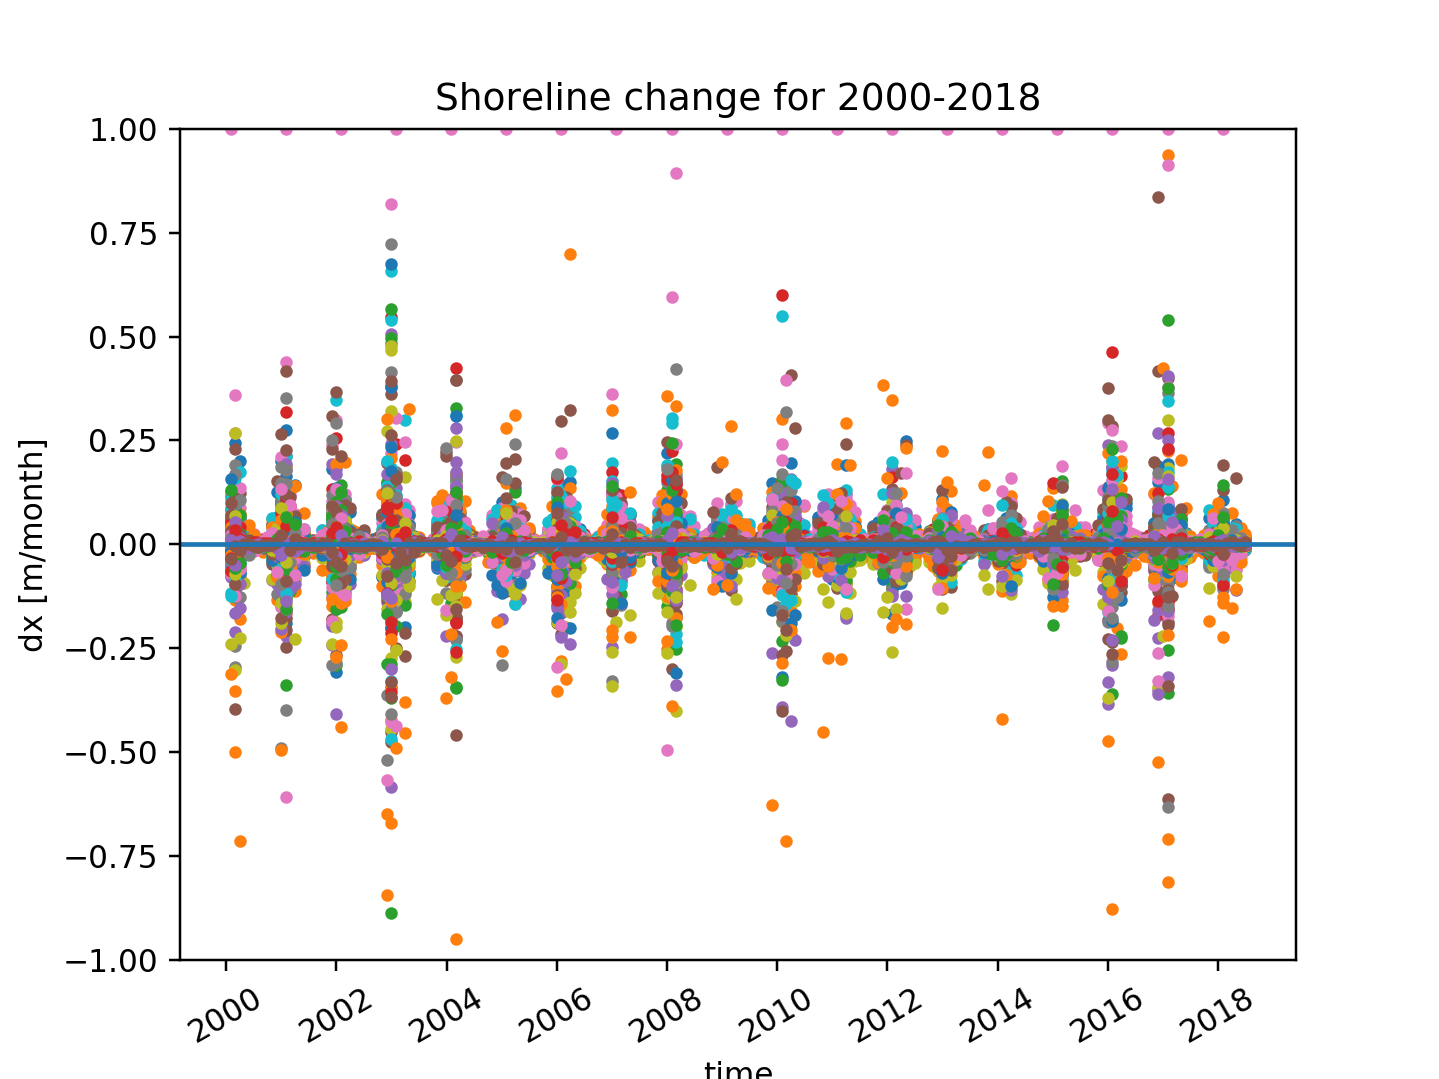

In [43]:
plt.figure()
plt.plot(dx_monthly,'.');
plt.xticks(rotation=30)
plt.xlabel('time')
plt.ylabel('dx [m/month]')
plt.title('Shoreline change for 2000-2018')
plt.ylim(-1,1)
plt.axhline(y=0)

### Future work: 
#### * continue building function to input various datasets of wave height and wave direction

#### * use xarray to better organize metadata and eventually plot things spatially

#### * compare changes predicted by CERC and Bruun to field data from USGS

#### *conduct parameter sensitivity tests - the CERC equation will overestmate Q if K is too high and underestimate if K is too low. This parameter ranges quite a bit in the literature.

#### *test skill of CDIP MOP model in the northern Monterey Bay. Conditions are expected to be similar to the southern bay but possibly of lower magnitude because northern bay is more protected? Testing skill will involve comparing dataset to field measurements of wave height and direction similar to O'Reilly et al. 2010. 


### Build model (this doesn't work currently but would be cool if it did)

In [37]:
#define model equations 
def CERC(WaveHeight,WaveDir, deltay, rho=None, K=None, g=None, gammab = None, hcl = None, B = None):
    '''
    This function calculates:
    Q [m^3/s]: longshore transport rate (volume of sediment in transport per unit time) [rows=time,cols=transectID],
    dx: cross shore change of shoreline due to longshore transport at discrete interval [rows=time,cols=dx south to north]
    The default function inputs will calculate monthly averages, but this can be changed by specifying g.

    The calculations are based on the CERC equation and Bruun Rule.
    WaveHeight input must be a dataframe, [time,transectID (or discrete subset of transect)]
    WaveDir must be the angle of wave approach to shore relative to shore normal, [time,transectID]
    WaveHeight and WaveDir MUST be the same dimensions.
    
    Optional inputs include the following model parameters:
    If no values are input the defaults are as follows:
    
    For CERC (calculating longshore transport volumes):
    rho = 1000 #kg/m^3, average density of seawater
    K = 0.147 #unitless, empirical constant (USACE, 2002)
    g = 9.8*2628000 #m/month^2, acceleration of gravity (multiply as needed for preffered time unit)
    gammab = 0.78 #unitless, breaker index 
    rhos = 1922 #kg/m^3, average density of sand
    
    For Brunn (calculating cross shore change due to longshore transport:
    hcl = 20 #closure depth....guessing for now
    B = 60 #height of berm or cliff....approximate for sunset but it changes throughout bay
    deltay = 20 #need to figure out what the alongshore length of each transect is

    '''
    #first set up all parameters to input value, or default if no value specifued
    rho = rho or 1000
    K = K or 0.39
    g = g or (9.8)
    gammab = gammab or 0.78    
    
    hcl = hcl or 20
    B = B or 20
    #deltay = deltay or 200
    
    #use CERC to calculate Q
    Q_lst = np.zeros(np.shape(Hs))
    Q_lst = (K/(16*np.sqrt(gammab)))*rho*(g**(3/2))*(Hs**(5/2))*np.sin(2*SN_Dp)
    
    #calculate dQ
    dQ_nans = Q_lst.diff(axis=1) #column labels don't make sense anymore
    dQ = dQ_nans.drop(columns='MO900') #this is very specific to this dataset and won't work for anything else currently
    
    #use Bruun rule and Q to calculate dx    
    dx = -(1/(hcl+B))*(dQdy)
   

    return Q,dx